# Prediction of Wild Blueberry Yield

## Importing modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import RidgeCV, LassoCV, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import catboost as ctb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

## Reading data

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head(5)

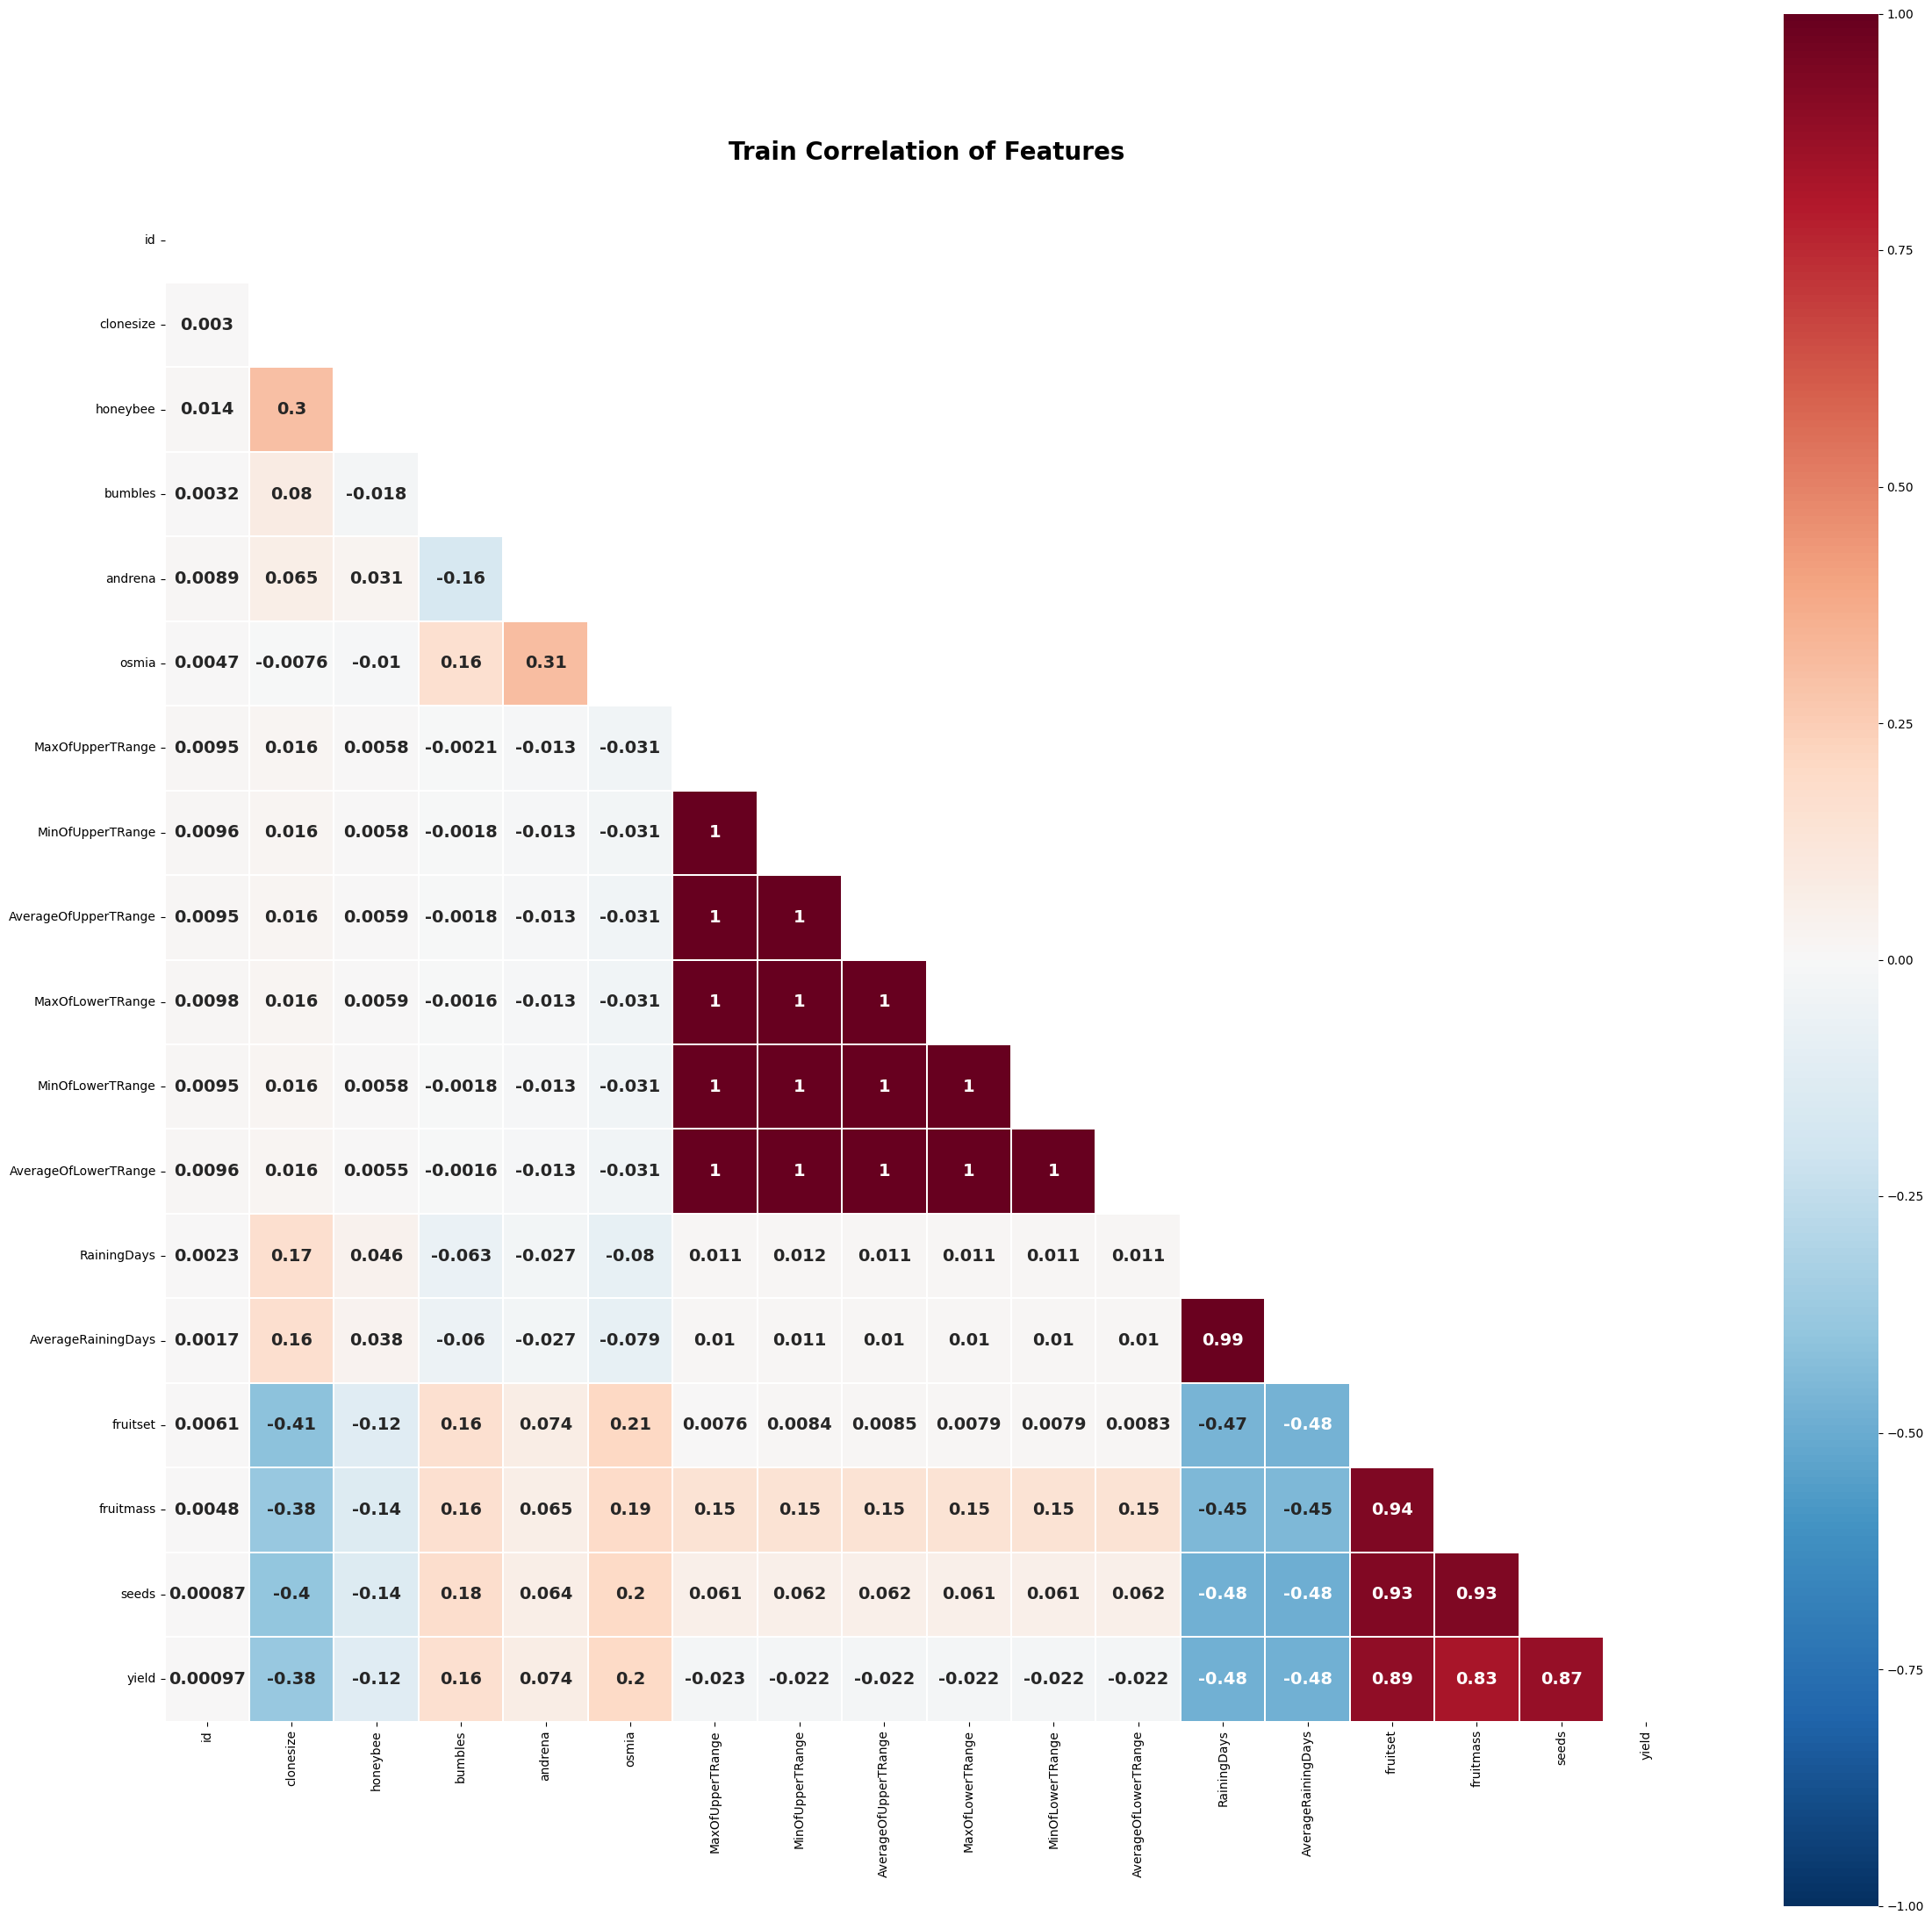

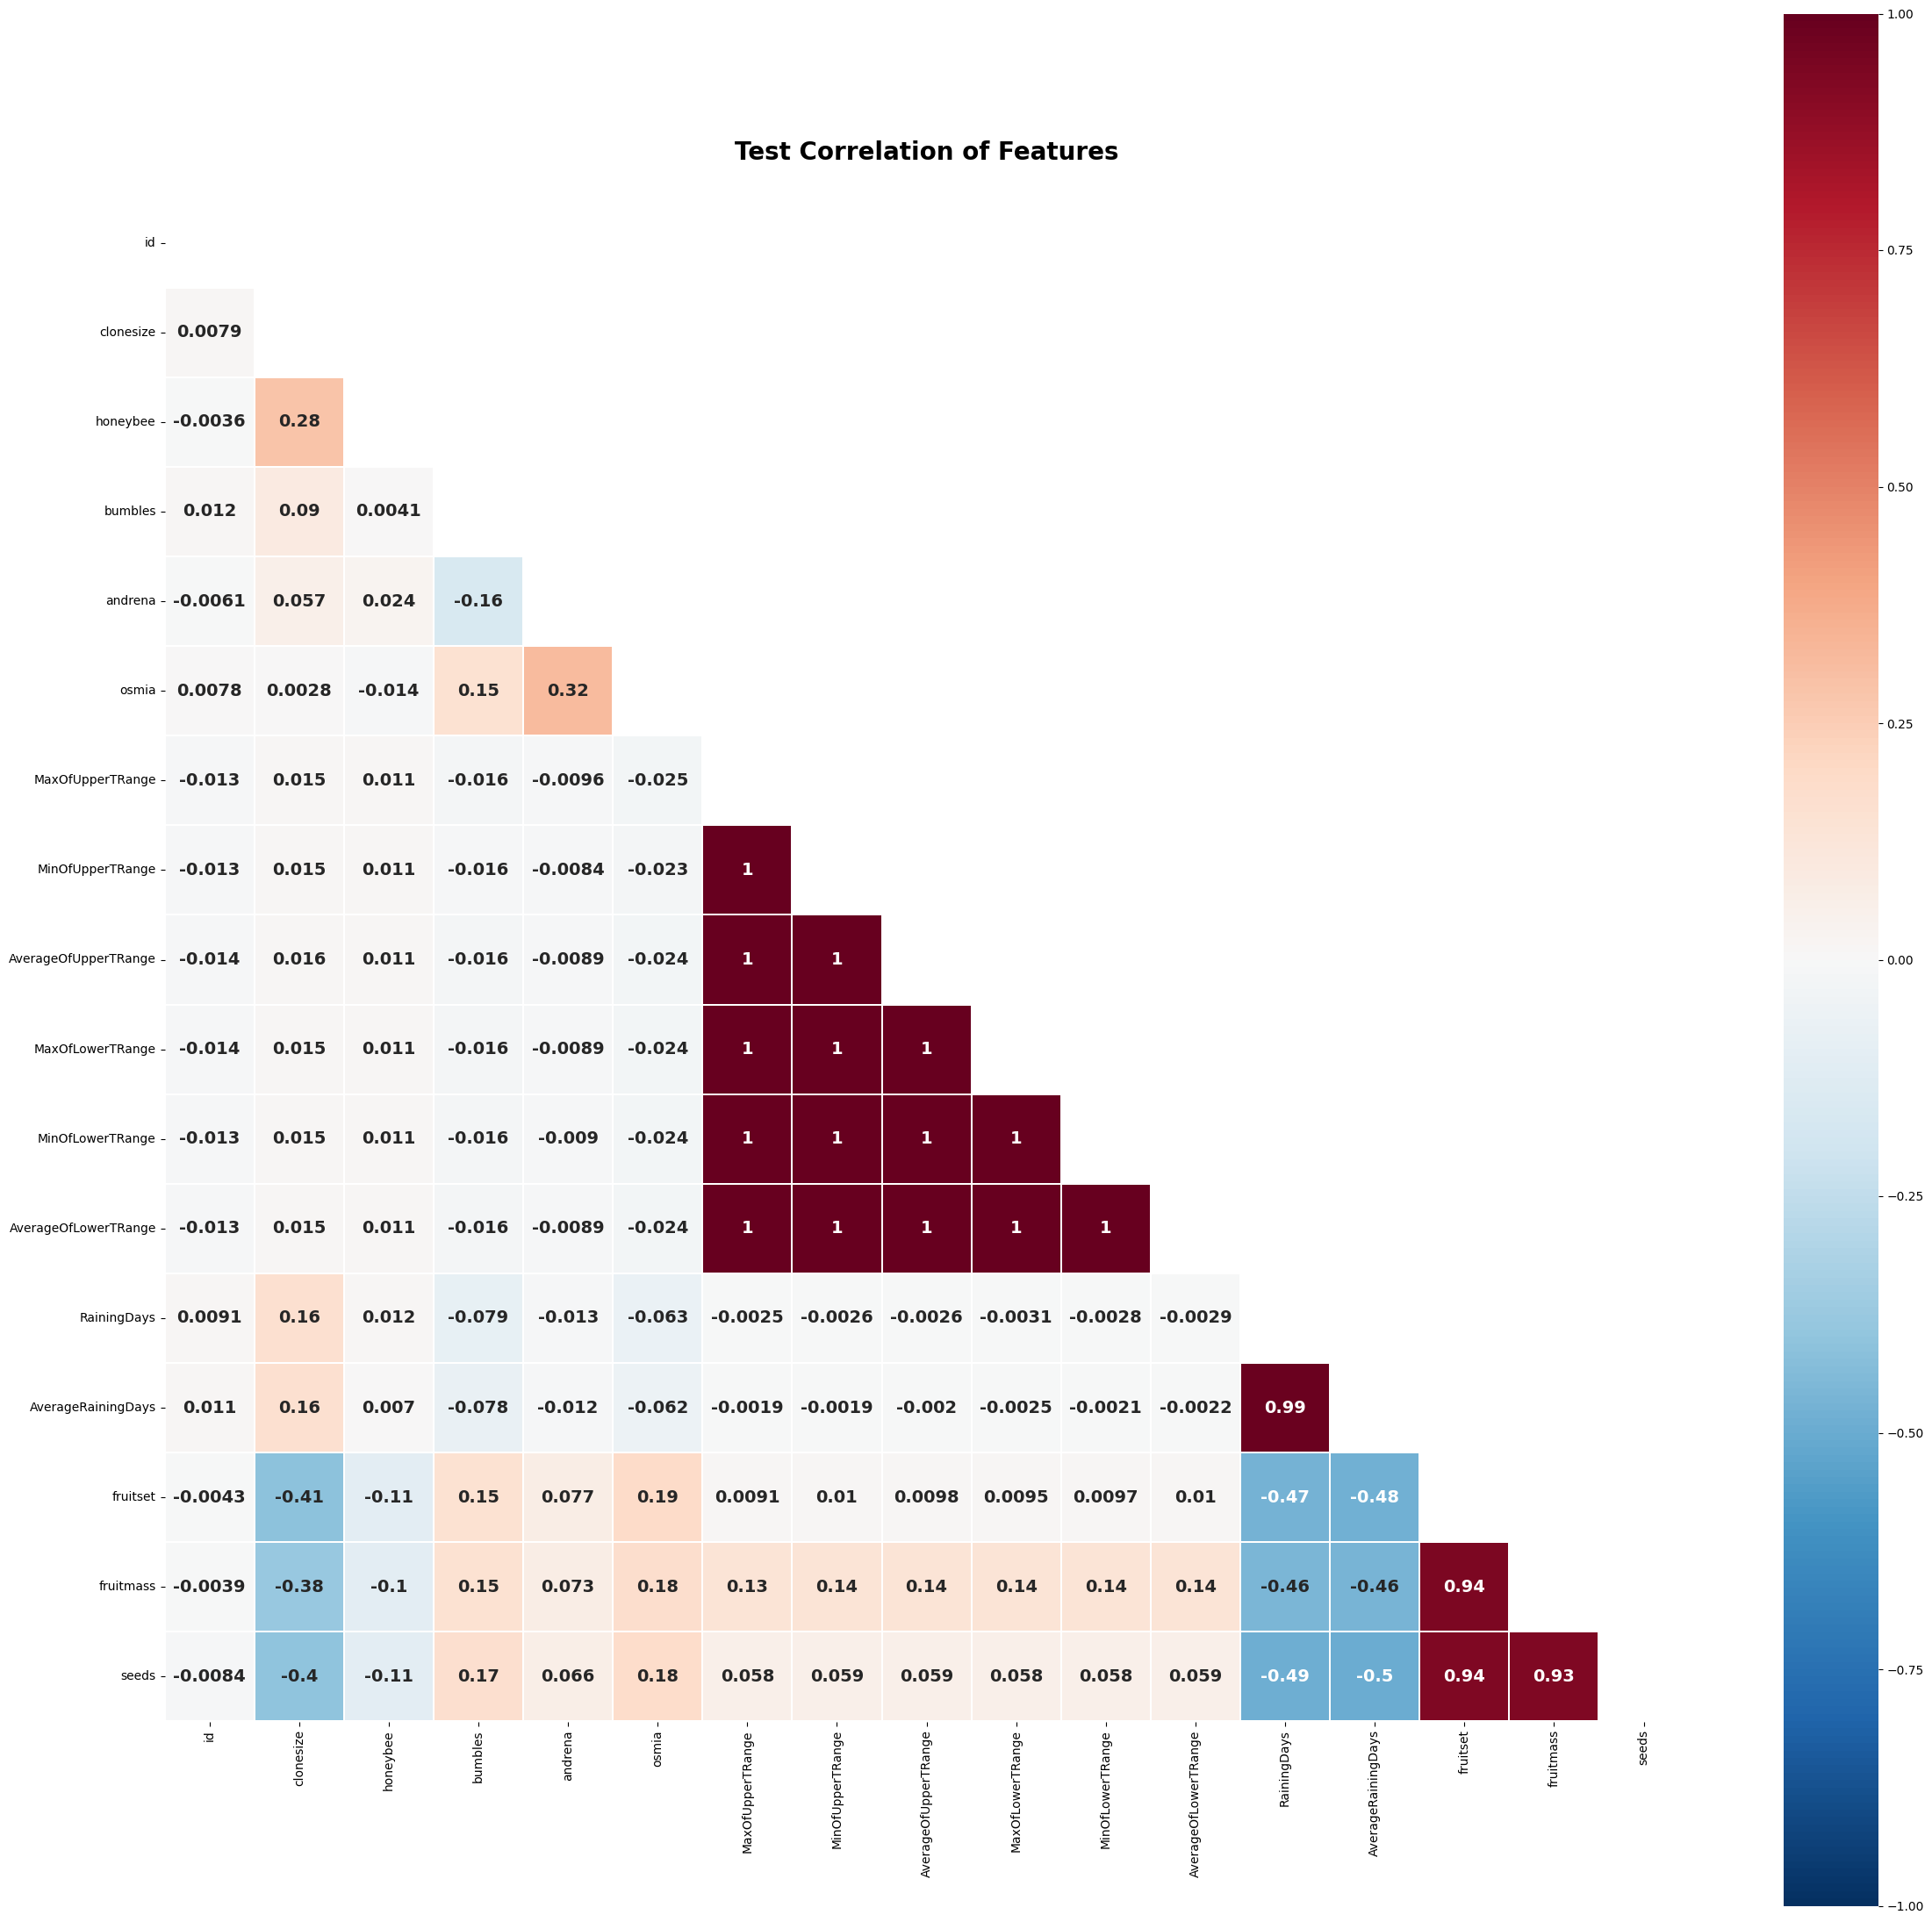

In [12]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(28, 28))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(df_train, title='Train')
plot_heatmap(df_test, title='Test')

In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,15289.0,7644.000000,4413.698468,0.000000,3822.000000,7644.000000,11466.000000,15288.000000
clonesize,15289.0,19.704690,6.595211,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,15289.0,0.389314,0.361643,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,15289.0,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000
andrena,15289.0,0.492675,0.148115,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,15289.0,0.592355,0.139489,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,15289.0,82.169887,9.146703,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,15289.0,49.673281,5.546405,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,15289.0,68.656256,7.641807,58.200000,64.700000,71.900000,71.900000,79.000000
MaxOfLowerTRange,15289.0,59.229538,6.610640,50.200000,55.800000,62.000000,62.000000,68.200000


Можно увидеть сильную зависимость между ('MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange'), а также ('RainingDays', 'AverageRainingDays') по идеи можно было бы оставить только по одной среди них, но на самом деле, все переменные важны для модели, также ввиду связи между 'fruitset' и 'seeds' можно добавить признак - fruit_seed

In [14]:
df_train['fruit_seed'] = df_train["fruitset"] * df_train["seeds"]
df_test['fruit_seed'] = df_test["fruitset"] * df_test["seeds"]

In [15]:
x_train, x_test = train_test_split(df_train.drop(['id', 'yield'], axis=1), train_size=0.7, shuffle=True, random_state=27)
y_train, y_test = train_test_split(df_train['yield'], train_size=0.7, shuffle=True, random_state=27)

Для начало попробую использовать случайный лес

In [16]:
model = RandomForestRegressor(n_jobs=-1, random_state=27)

model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=27)

In [17]:
pred = model.predict(x_train)
pred1 = model.predict(x_test)

In [18]:
mean_absolute_error(y_train, pred), mean_absolute_error(y_test, pred1)

(137.44803370537122, 369.96588781249653)

Неплохо - 369 на валидации, теперь попробуем оптимизировать

In [19]:
tree = RandomForestRegressor(n_jobs=-1, random_state=27)

param_grid = {'max_depth': [5, 6, 7, 8, 9, 10, 15, 20]}
cv = 5

grid_search = GridSearchCV(tree, param_grid=param_grid, cv=cv)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'max_depth': 7}


Best - 8

In [20]:
tree = RandomForestRegressor(max_depth=8, n_jobs=-1, random_state=27)

param_grid = {'min_samples_leaf': [1, 5, 10, 15, 20]}
cv = 5

grid_search = GridSearchCV(tree, param_grid=param_grid, cv=cv)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'min_samples_leaf': 10}


Best - 10

In [21]:
tree = RandomForestRegressor(max_depth=8, min_samples_leaf=10, n_jobs=-1, random_state=27)

param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600]}
cv = 5

grid_search = GridSearchCV(tree, param_grid=param_grid, cv=cv)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'n_estimators': 600}


Best - 600

In [22]:
model = RandomForestRegressor(n_estimators=600, max_depth=8, min_samples_leaf=10, n_jobs=-1, random_state=27)

model.fit(x_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=10, n_estimators=600,
                      n_jobs=-1, random_state=27)

In [23]:
pred = model.predict(x_train)
pred1 = model.predict(x_test)

In [24]:
mean_absolute_error(y_train, pred), mean_absolute_error(y_test, pred1)

(326.9080670905176, 349.75039859907855)

349 on validation

In [25]:
model = RandomForestRegressor(n_estimators=600, max_depth=8, min_samples_leaf=10, n_jobs=-1, random_state=27)

model.fit(df_train.drop(['id', 'yield'], axis=1), df_train['yield'])

RandomForestRegressor(max_depth=8, min_samples_leaf=10, n_estimators=600,
                      n_jobs=-1, random_state=27)

In [163]:
pred = model.predict(df_test.drop('id', axis=1))

In [164]:
df_sub = pd.read_csv('sample_submission.csv')

df_sub.loc[:, 'yield'] = pred

df_sub.to_csv('my_submission_file.csv', index=False)

351 на тестовой выборке, из деревьев выжал все по максимуму, теперь попробуем оптимизировать CatBoost, с помощью Optuna

In [27]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    depth = trial.suggest_int('depth', 4, 10)
    lr = trial.suggest_float('learning_rate', 1e-2, 0.5, log=True)
    l2 = trial.suggest_float('l2_leaf_reg', 1e-14, 1e-4, log=True)
    ran_st = trial.suggest_float('random_strength', 0.1, 0.4, log=True)
    mb = trial.suggest_int('max_bin', 200, 500, log=True)
    od_w = trial.suggest_int('od_wait', 20, 100)
    gp = trial.suggest_categorical('grow_policy', ['Lossguide','Depthwise','SymmetricTree'])
    
    model = ctb.CatBoostRegressor(n_estimators=n_estimators, loss_function='MAE',
                                  eval_metric='MAE', random_state=42,
                                  grow_policy=gp, depth=depth, learning_rate=lr,
                                 l2_leaf_reg=l2, random_strength=ran_st, max_bin=mb, od_wait=od_w)
    
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=900, verbose=False)
    y_pred = model.predict(x_test)
    return mean_absolute_error(y_test, y_pred)

In [152]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100,show_progress_bar=True)

C:\Users\Andrey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
Best trial: 81. Best value: 337.79: 100%|████████████████████████████████████████████| 100/100 [26:26<00:00, 15.86s/it]


In [153]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  337.79035869722713
  Params: 
    n_estimators: 899
    depth: 10
    learning_rate: 0.017371886961446835
    l2_leaf_reg: 9.448672727897611e-13
    random_strength: 0.11632008349952269
    max_bin: 410
    od_wait: 44
    grow_policy: Lossguide


In [ ]:
cb3_params = {
    'n_estimators': 899,
    'depth': 10,
    'learning_rate': 0.017371886961446835,
    'l2_leaf_reg': 9.448672727897611e-13,
    'random_strength': 0.11632008349952269,
    'max_bin': 410,
    'od_wait': 44,
    'grow_policy': 'Lossguide',
    'od_type': 'Iter',
    'eval_metric': 'MAE',
    'loss_function': 'MAE',
    'random_state': 42,
    'silent': True
}

Получили результаты оптимизации, теперь попробуем применить и проверим результат

In [161]:
model = ctb.CatBoostRegressor(**cb3_params)

model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=900, verbose=False)

In [134]:
pred = model.predict(x_train)
mean_absolute_error(y_train, pred)

312.69094545252256

In [162]:
pred = model.predict(x_test)
mean_absolute_error(y_test, pred)

337.79035869722713

337 на валидационной выборке, отличный результат по отношению к деревьям

In [94]:
pred = model.predict(df_test.drop('id', axis=1))

df_sub = pd.read_csv('sample_submission.csv')

df_sub.loc[:, 'yield'] = pred

df_sub.to_csv('my_submission_file.csv', index=False)

342 на тестовой выборке CatBoost справился в разы лучше деревьев, так что оставим этот результат